In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from PIL import Image
import os

# -------------------------
# Config
# -------------------------
class Config:
    data_dir = r"C:\Users\ADMIN\Pictures\New folder\100mergers"  # contains hazard/ and non_hazard/ fetches dataset
    #defines batch size and epoch and leaning rate
    batch_size = 8
    img_size = 224
    num_workers = 2
    lr = 1e-4
    num_epochs = 25
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_save_path = "hazard_classifier_small2.pth"

# -------------------------
# Dataset
# -------------------------
def get_dataloaders(config, split_ratio=0.7):
    transform = transforms.Compose([
        transforms.Resize((config.img_size, config.img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(config.data_dir, transform=transform)
    class_names = dataset.classes

    # Split into train/test
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    test_size = total_size - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True,
                              num_workers=config.num_workers)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False,
                             num_workers=config.num_workers)

    return train_loader, test_loader, class_names, dataset

# -------------------------
# Model
# -------------------------
def initialize_model(config, num_classes=2):
    model = models.resnet18(pretrained=True)  # smaller model for small dataset
    for param in model.parameters():
        param.requires_grad = False  # freeze feature extractor

    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128, num_classes)
    )
    return model.to(config.device)

# -------------------------
# Train
# -------------------------
def train_model(model, train_loader, config):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=config.lr)

    for epoch in range(config.num_epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(config.device), labels.to(config.device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Epoch {epoch+1}/{config.num_epochs} "
              f"Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    torch.save(model.state_dict(), config.model_save_path)
    print(f"✅ Model saved to {config.model_save_path}")
    return model

# -------------------------
# Evaluate
# -------------------------
def evaluate_confusion_matrix(model, test_loader, config, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(config.device), labels.to(config.device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (Test Set)")
    plt.show()

# -------------------------
# Predict single image
# -------------------------
def predict_image(model, image_path, config, class_names):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((config.img_size, config.img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(config.device)

    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    return class_names[preds[0]]

# -------------------------
# Main
# -------------------------
if __name__ == "__main__":
    cfg = Config()
    train_loader, test_loader, class_names, dataset = get_dataloaders(cfg)

    model = initialize_model(cfg, num_classes=2)
    model = train_model(model, train_loader, cfg)

    # Evaluate on test set
    evaluate_confusion_matrix(model, test_loader, cfg, class_names)

    # # Example inference
    # test_img = "/content/download.jpeg"
    # pred = predict_image(model, test_img, cfg, class_names)
    # print(f"Prediction: {pred}")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Accuracy: 0.9163
Precision: 0.8627
Recall: 0.9670
F1-Score: 0.9119


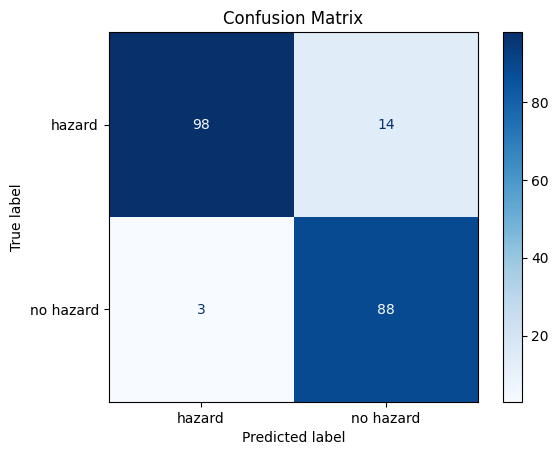

ROC-AUC: 0.9673


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score)
import matplotlib.pyplot as plt

class Config:
    data_dir = r"/content/drive/MyDrive/cnndata"
    batch_size = 8
    img_size = 224
    num_workers = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_save_path = "hazard_classifier_small2.pth"

def get_test_loader(cfg, split_ratio=0.7):
    transform = transforms.Compose([
        transforms.Resize((cfg.img_size, cfg.img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    dataset = datasets.ImageFolder(cfg.data_dir, transform=transform)
    total = len(dataset)
    train_len = int(total * split_ratio)
    test_len = total - train_len
    _, test_set = random_split(dataset, [train_len, test_len])
    test_loader = DataLoader(test_set, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
    return test_loader, dataset.classes

def load_model(cfg, num_classes):
    model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128, num_classes)
    )
    model.load_state_dict(torch.load(cfg.model_save_path, map_location=cfg.device))
    model.to(cfg.device)
    model.eval()
    return model

def evaluate(model, test_loader, cfg, class_names):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(cfg.device)
            labels = labels.to(cfg.device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
    print(f"Precision: {precision_score(all_labels, all_preds, average='binary'):.4f}")
    print(f"Recall: {recall_score(all_labels, all_preds, average='binary'):.4f}")
    print(f"F1-Score: {f1_score(all_labels, all_preds, average='binary'):.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    if len(class_names) == 2:
        all_probs = []
        with torch.no_grad():
            for inputs, _ in test_loader:
                inputs = inputs.to(cfg.device)
                outputs = model(inputs)
                probs = nn.functional.softmax(outputs, dim=1)[:, 1]
                all_probs.extend(probs.cpu().numpy())
        print(f"ROC-AUC: {roc_auc_score(all_labels, all_probs):.4f}")

if __name__ == "__main__":
    cfg = Config()
    test_loader, classes = get_test_loader(cfg)
    model = load_model(cfg, num_classes=len(classes))
    evaluate(model, test_loader, cfg, classes)
